In [2]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Get Data

In [38]:
df = pd.read_csv("dataframe.csv")
df.time = pd.to_datetime(df.time, dayfirst = True)
time = df['time'].values

df['time'] = pd.to_datetime(df.time , format = '%d/%m/%Y %H.%M.%S')
df.set_index('time',inplace=True)
points_per_day = 288 

df.tail()

,temperature,humidity,pressure,people
time,,,,
2020-07-15 12:10:00+00:00,28.65,38.00,1016.5,0.0
2020-07-15 12:15:00+00:00,28.65,38.00,1016.5,0.0
2020-07-15 12:20:00+00:00,28.70,38.30,1016.5,0.0
2020-07-15 12:25:00+00:00,28.65,38.45,1016.5,0.0
2020-07-15 12:30:00+00:00,28.75,38.70,1016.5,0.0


# Clean Data 

In [25]:
### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [40]:

### ADJUST AND CLEAN DATA ###

df_external = pd.DataFrame(df.index)

for col in df.columns:
    
    if df[col].dtype == object: # correct type
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    
    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans
        
    if col in ['T','RH','AH']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)

temperature : 0.0
humidity : 0.0
pressure : 0.0
people : 0.0


In [41]:
df_external['month'] = df_external.time.dt.month
df_external['day'] = df_external.time.dt.dayofweek
df_external['hour'] = df_external.time.dt.hour

df_external = cycle_encode(df_external, ['month','day','hour'])
df_external.drop(['month','day','hour'], axis=1, inplace=True)
df_external.set_index('time', inplace=True)

print(df_external.shape)
df_external.head()

(2304, 6)


,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
time,,,,,,
2020-07-07 12:35:00+00:00,-2.449294e-16,1.0,0.866025,0.5,-0.136167,-0.990686
2020-07-07 12:40:00+00:00,-2.449294e-16,1.0,0.866025,0.5,-0.136167,-0.990686
2020-07-07 12:45:00+00:00,-2.449294e-16,1.0,0.866025,0.5,-0.136167,-0.990686
2020-07-07 12:50:00+00:00,-2.449294e-16,1.0,0.866025,0.5,-0.136167,-0.990686
2020-07-07 12:55:00+00:00,-2.449294e-16,1.0,0.866025,0.5,-0.136167,-0.990686


In [43]:
### SPLIT TRAIN TEST ###

train_time = time[:int(len(df)*0.8)]
train = df[:int(len(df)*0.8)].copy()

test_time = time[int(len(df)*0.8):]
test = df[int(len(df)*0.8):].copy()

print(train.shape, test.shape)


(1843, 4) (461, 4)


In [46]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train_time, train[name], label='train')
    plt.plot(test_time, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

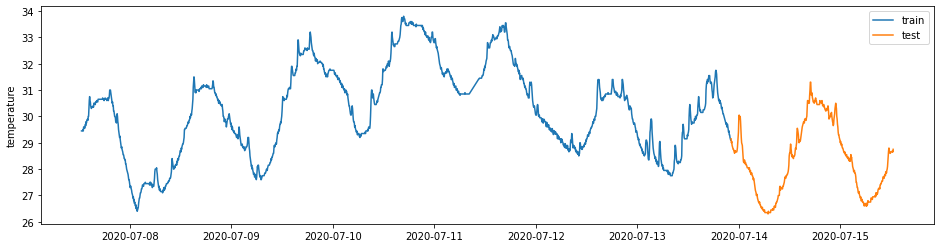

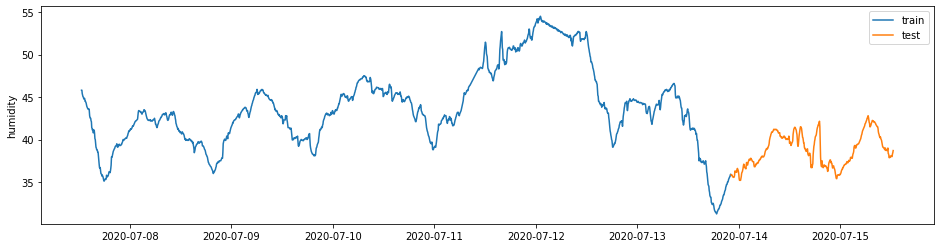

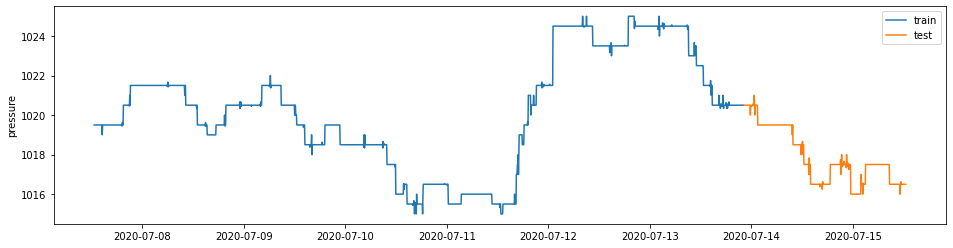

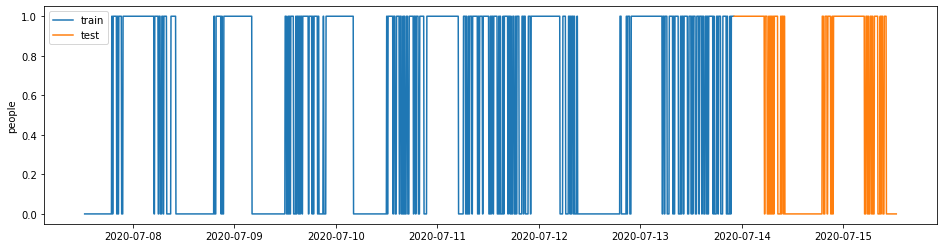

In [47]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

/home/adamf42/anaconda3/envs/forecasting_service/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/adamf42/anaconda3/envs/forecasting_service/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


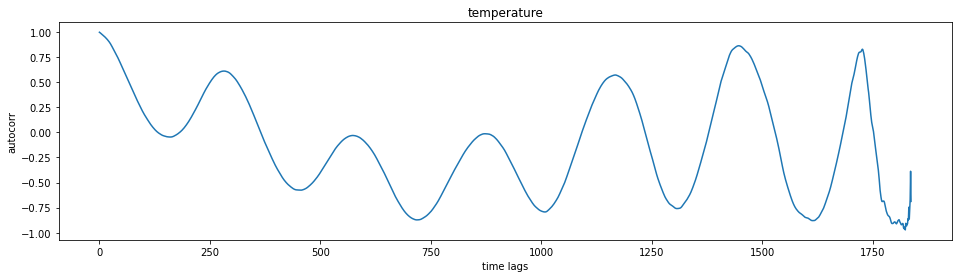

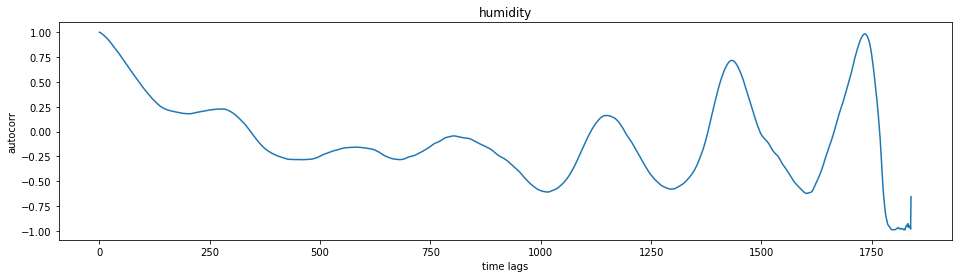

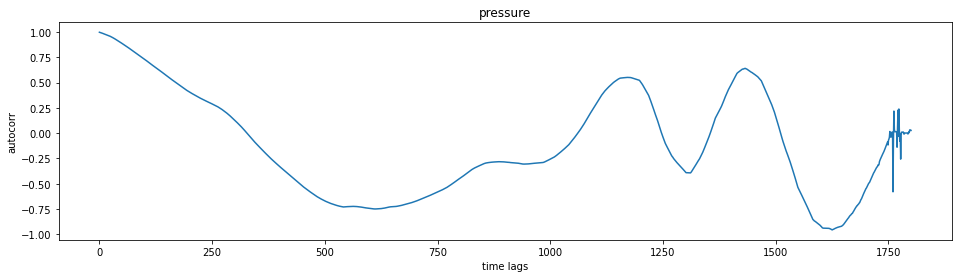

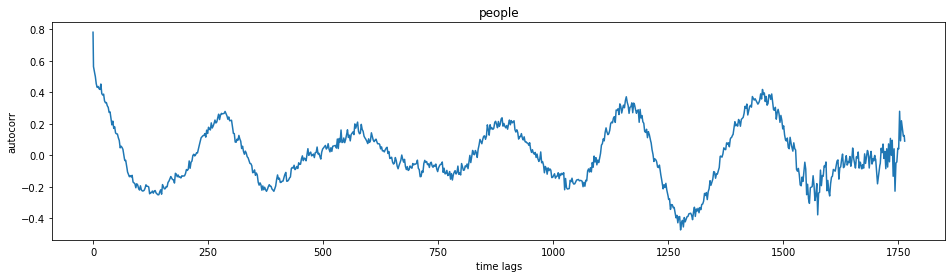

In [48]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [181]:
### OPERATE DIFFERENTIATION ###

period = 288

df_diff = df.diff(period).dropna()
df_external = df_external.iloc[period:].copy()


test = df_diff.cumsum()
test.head()

,temperature,humidity,pressure,people
time,,,,
2020-07-08 12:35:00+00:00,-0.50,-5.10,1.000000,0.0
2020-07-08 12:40:00+00:00,-0.95,-10.20,2.000000,0.0
2020-07-08 12:45:00+00:00,-1.30,-15.00,3.000000,0.0
2020-07-08 12:50:00+00:00,-1.55,-19.70,3.833333,0.0
2020-07-08 12:55:00+00:00,-1.55,-24.45,4.833333,0.0


In [62]:
### SPLIT DIFFERENTIAL DATA IN TRAIN AND TEST ###

train_diff = df_diff.iloc[:len(train)-period,:].copy()
test_diff = df_diff.iloc[len(train)-period:,:].copy()

train_init = df.iloc[:len(train)-period,:].copy()
test_init = df.iloc[len(train)-period:-period,:].copy()

train_ext = df_external.iloc[:len(train)-period,:].copy()
test_ext = df_external.iloc[len(train)-period:,:].copy()

print(train_diff.shape, train_init.shape, train_ext.shape)
print(test_diff.shape, test_init.shape, test_ext.shape)

(1555, 4) (1555, 4) (1555, 6)
(461, 4) (461, 4) (160, 6)


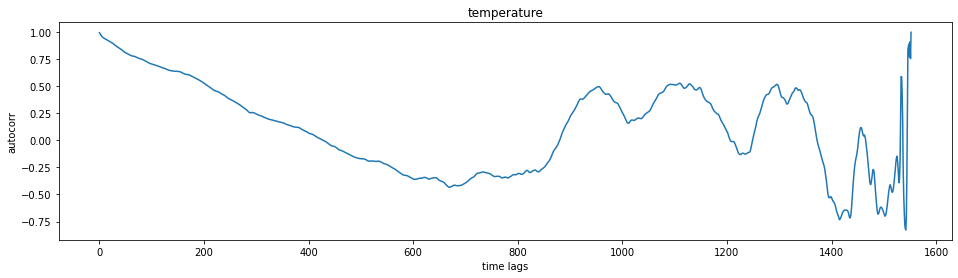

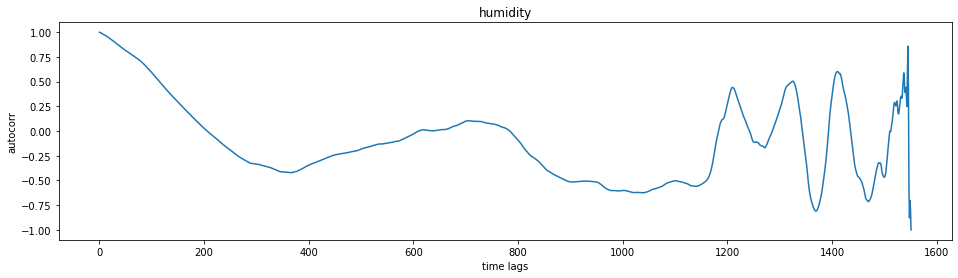

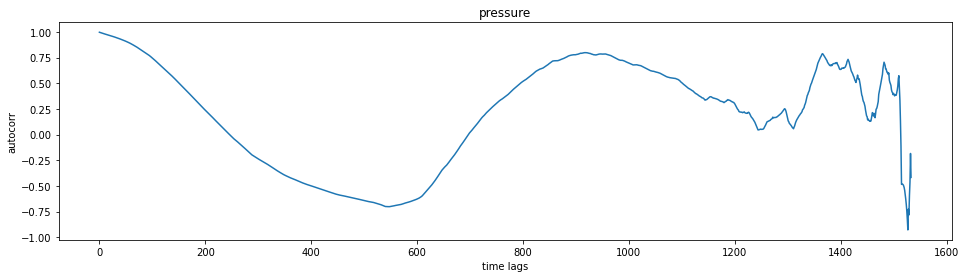

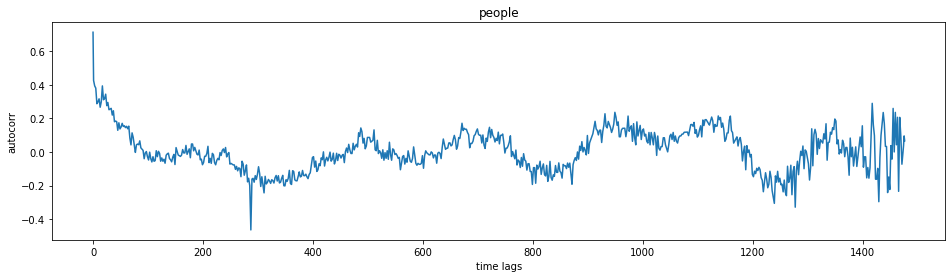

In [63]:
### PLOT DIFFERENTIAL SERIES ###

for col in df.columns:
    plot_autocor(col, train_diff)

In [67]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,300):
    model = VAR(endog=train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 299 BEST AIC: -19.22434382888629


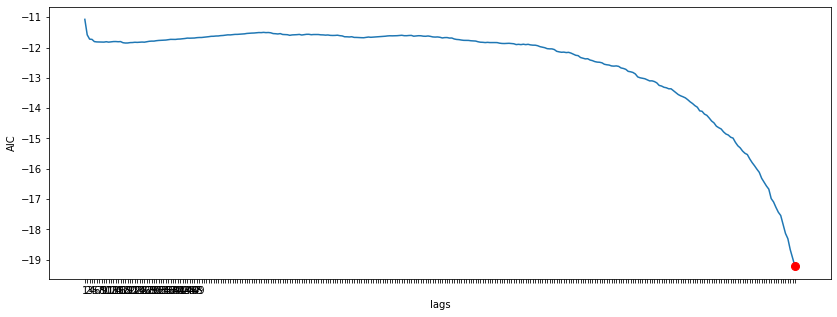

In [68]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [69]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train_diff.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

-19.22434382888629

In [177]:
### UTILITY FUNCTION FOR RETRIVE VAR PREDICTIONS ###

def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    print(pred)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [171]:
test.head()

,temperature,humidity,pressure,people
time,,,,
2020-07-13 22:10:00+00:00,29.15,35.85,1020.5,1.0
2020-07-13 22:15:00+00:00,29.00,35.80,1020.5,1.0
2020-07-13 22:20:00+00:00,29.05,35.85,1020.5,1.0
2020-07-13 22:25:00+00:00,28.90,35.80,1020.5,1.0
2020-07-13 22:30:00+00:00,28.85,35.65,1020.5,1.0


In [ ]:
def invert_transformation(df_train, df_forecast, diff):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
    return df_fc

In [182]:
### RETRIVE PREDICTION AND OBTAIN THE CORRESPONDING ACTUAL VALUES ###

time = '2020-07-13 22:10:00+00:00'
forward = 449
date_range = pd.date_range(time, periods=forward+1, freq='300S', closed='right')

final_pred = retrive_prediction(df_diff.loc[:time], df.loc[:time], steps = forward)
final_true = df.loc[date_range[0]:date_range[date_range.size-1]]

print(len(final_pred))

print(len(final_true))

[[  -293.    305.    -96.    628.]
 [   -62.    384.   -135.    179.]
 [    60.   1004.    969.   -842.]
 ...
 [  1115. -28292.  -6516.   1797.]
 [  -689. -21320.   4699.  -6952.]
 [  1308. -20119.  -6576.   7295.]]
449
449


In [183]:
cols = df.columns
x = []
for col in cols:
    diff_results = df[col] + df_diff[col].shift(-1)
    x.append(diff_results)
diff_df_inverted = pd.concat(x, axis=1)

diff_df_inverted

,temperature,humidity,pressure,people
time,,,,
2020-07-07 12:35:00+00:00,NaN,NaN,NaN,NaN
2020-07-07 12:40:00+00:00,NaN,NaN,NaN,NaN
2020-07-07 12:45:00+00:00,NaN,NaN,NaN,NaN
2020-07-07 12:50:00+00:00,NaN,NaN,NaN,NaN
2020-07-07 12:55:00+00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2020-07-15 12:10:00+00:00,28.35,36.50,1014.5,0.0
2020-07-15 12:15:00+00:00,28.55,37.00,1014.5,0.0
2020-07-15 12:20:00+00:00,28.65,37.35,1015.5,0.0


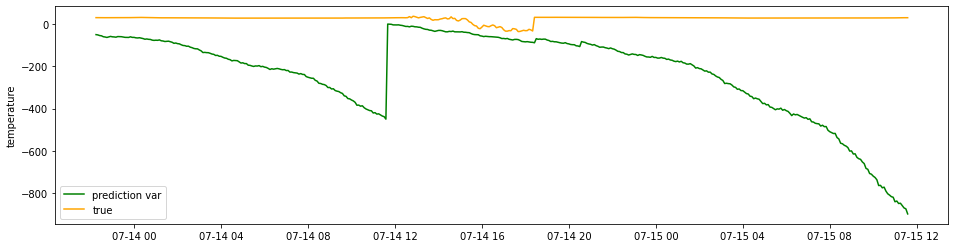

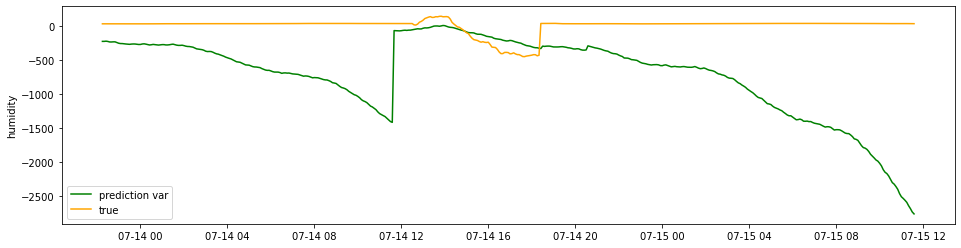

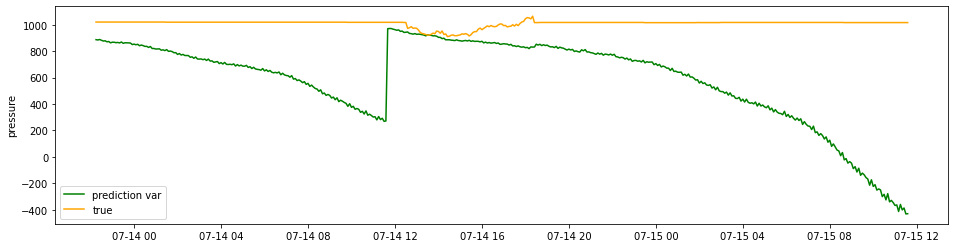

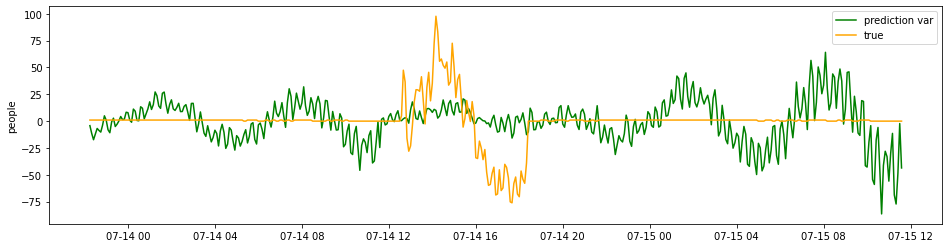

In [176]:
### PLOT ACTUAL vs PREDICTION ###

for i,col in enumerate(df.columns):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range, final_true[col].values, c='orange', label='true')
    
    plt.ylabel(col); plt.legend()
    plt.show()